In [46]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as ss
import pickle
strDataDir = '/home/mqbssaby/transfer/syn'  # where data lives
numExperiments = 100  # number of experiments

In [47]:
# plotly
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

In [48]:
def plotBranchModel(B, pt, Y, ttestl, mul, varl, Phi, figsizeIn=(5, 5), lw=3., fs=10, labels=None,
                    fPlotPhi=True, fPlotVar=False, ax=None):
    ''' Plotting code that does not require access to the model but takes as input predictions. '''
    if(ax is None):
        fig = plt.figure(figsize=figsizeIn)
        ax = fig.gca()
    else:
        fig = plt.gcf()
    d = 0  # constraint code to be 1D for now
    for f in range(3):
        mu = mul[f]
        var = varl[f]
        ttest = ttestl[f]
        mean, = ax.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        if(fPlotVar):
            ax.plot(ttest.flatten(), mu[:, d] + 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
            ax.plot(ttest, mu[:, d] - 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
    v = ax.axis()
    ax.plot([B, B], v[-2:], '-m', linewidth=lw)
    # Plot Phi or labels
    if(fPlotPhi):
        gp_num = 1  # can be 0,1,2 - Plot against this
        PhiColor = ax.scatter(pt, Y[:, d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        # plt.colorbar(PhiColor, label='GP {} assignment probability'.format(gp_num))
    return fig

def plotScatterMeanRanking(meanRank, title, Btry):
    ''' Function to do bubble plot of rank. Size of marker proportional to error'''
    traceCell= list()
    layout = go.Layout(showlegend=True, title='Mean ranking %s' % title,
                       annotations=list())
    for r in range(meanRank.shape[0]):
        traceCell.append(go.Scatter(
            x = Btry + 0.15*np.random.rand(len(Btry)),
            y = meanRank[r, :],
            mode='markers',
            name = r,
            text = r,
            marker={'size': 10*np.abs(meanRank[r, :] - np.array([1,2,3,4]))}  # make size prop to error
            ))
    fig = go.Figure(data=traceCell, layout=layout)
    iplot(fig, filename='MeanRank%s' % title)

In [49]:
def GetRunData(fSparse, nrun, nTrueB, fPrint=True):
    assert nTrueB >=0 and nTrueB <=3, 'Should be 0 to 3'
    rallDescr = ['Full', 'Sparse']
    fullNamel = ['%s/runArrayJob_%s' % (strDataDir, rallDescr[0]),
                 '%s/runArrayJob_%s' % (strDataDir, rallDescr[1])]
    strfile = fullNamel[fSparse]+str(nrun)+'.p'
    if(fPrint):
        print('Open files %s' % strfile)
    r = pickle.load(open(strfile, "rb"))
    # Get objective functions and GP fits
    BgridSearch = r['BgridSearch']
    Btry = r['Btry']
    Btry[-1] = 1  # integrate GP as 1
    obj = r['mlist'][nTrueB]['obj']
    gridSearchData = r['mlist'][nTrueB]
    gridSearchGPs = r['mlist'][nTrueB]['mlocallist']
    assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
    iMin = np.argmin(obj)  # we could also plot other GPs on the grid
    gpPlot = gridSearchGPs[iMin]  
    return obj, gridSearchData, gridSearchGPs, BgridSearch, Btry 

In [50]:
def GetPosteriorB(fSparse, fPrint=False):
    '''
    Return posterior on B for each experiment
    '''
    _, _, _, BgridSearch, Btry = GetRunData(fSparse, 1, 0, False)  # Get Bgrid and Btry. Experiments is 1-based
    posteriorB = np.zeros((numExperiments, len(Btry), len(BgridSearch))) # nexp X trueB X B grid src
    posteriorB[:] = np.nan    
    for ns in range(1, numExperiments+1):        
        for ib, b in enumerate(Btry):
            obj, gridSearchData, gridSearchGPs, BgridSearchI, BtryI = GetRunData(fSparse, ns, ib, False)
            assert set(BtryI) == set(Btry), 'Btry ust be the same or we are loading wrong file.'
            assert set(BgridSearchI) == set(BgridSearch), 'BgridSearch must be the same or we are loading wrong file.'
            # for each trueB calculate posterior over grid
            # ... in a numerically stable way
            o = -obj
            pn = np.exp(o - np.max(o))
            p = pn/pn.sum()
            assert np.any(~np.isnan(p)), 'Nans in p! %s' % str(p)
            assert np.any(~np.isinf(p)), 'Infinities in p! %s' % str(p)
            posteriorB[ns-1, ib, :] = p
            if(fPrint):
                print('%g:B=%s probs=' % (ns, b), np.round(p, 2))
    return posteriorB, Btry, BgridSearch
posteriorBFull, Btry, BgridSearch = GetPosteriorB(False, False)
posteriorBSparse, Btry, BgridSearch = GetPosteriorB(True, False)

=========> Full
[  5.20400000e-02   0.00000000e+00   1.38900000e-02   2.96900000e-02
   3.31000000e-03   3.50000000e-04   1.07000000e-03   1.05000000e-03
   8.98600000e-01   0.00000000e+00   0.00000000e+00]
pcalc
 [  5.20400000e-02   0.00000000e+00   1.38900000e-02   2.96900000e-02
   3.31000000e-03   3.50000000e-04   1.07000000e-03   1.05000000e-03
   8.98600000e-01   0.00000000e+00   0.00000000e+00]
=========> Sparse
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pcalc
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


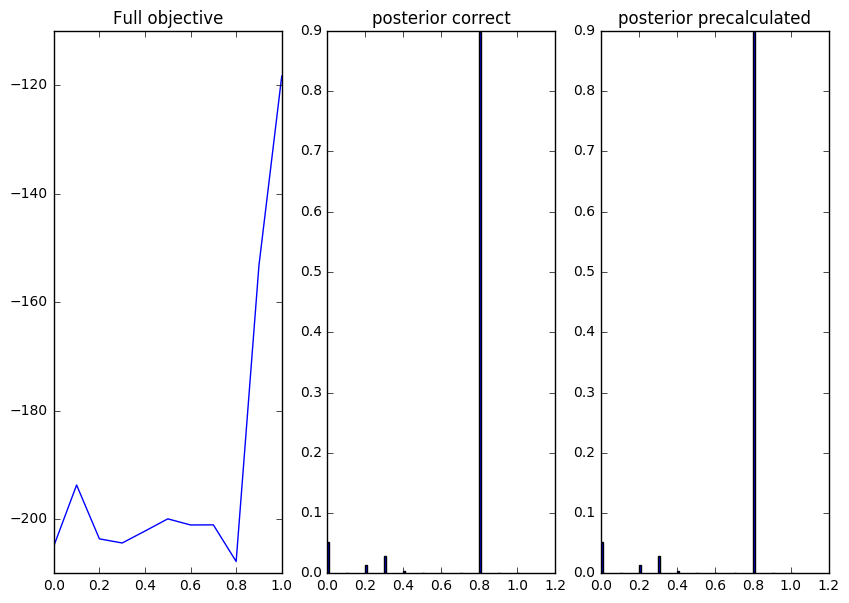

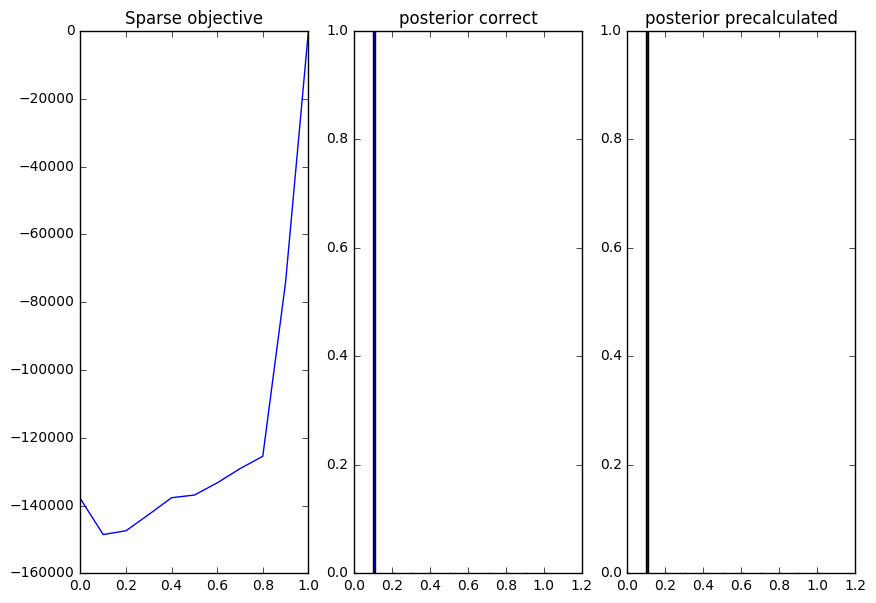

In [51]:
# Checking code - load a particular trueB, run 
nTrueB = 2
runCheck = 98
data = ['Full', 'Sparse']
for ds in data:
    print('=========>', ds)
    r = pickle.load(open('/home/mqbssaby/transfer/syn/runArrayJob_%s%g.p'%(ds,runCheck), "rb"))
    BgridSearch = r['BgridSearch']
    Btry = r['Btry']
    Btry[-1] = 1  # integrate GP as 1
    obj = r['mlist'][nTrueB]['obj']
    # Plot
    f, axarr = plt.subplots(1, 3, figsize=(10, 7))
    ax = axarr.flatten()
    ax[0].plot(BgridSearch, obj)
    ax[0].set_title('%s objective' % ds)
    # calculate posterior
    objSamples = -obj
    pun = np.exp(objSamples)
    pun = pun/pun.sum()
    # numerically stable way
    o = objSamples
    pn = np.exp(o - np.max(o))
    pns = pn/pn.sum()
    p = pns 
    print(np.round(p, 5))
    ax[1].set_title('posterior correct')
    ax[1].bar(BgridSearch, p, 0.01)
    # Plot calculated posterior
    if(ds == 'Full'):
        pcalc = posteriorBFull[runCheck-1, nTrueB, :]  # experiment number if 1 based
    else:
        pcalc = posteriorBSparse[runCheck-1, nTrueB, :]  # experiment number if 1 based
    print('pcalc\n', np.round(pcalc, 5))
    ax[2].bar(BgridSearch, pcalc, 0.01)
    ax[2].set_title('posterior precalculated')
    assert np.allclose(pcalc, p)

In [52]:
def GetMeanRank(posteriorB, Btry, BgridSearch):
    '''
    Return mean rank for synthetic experiment
    '''
    numExps = posteriorB.shape[0]
    assert numExps == numExperiments
    numTrueB = posteriorB.shape[1]
    assert numTrueB == len(Btry)
    numGrid = posteriorB.shape[2]
    assert numGrid == len(BgridSearch)
    # for each experiment
    meanRank = np.zeros((numExps, numTrueB))  # nexp X num true B
    meanRank[:] = np.nan
    nMC = 100  # do Monte Carlo estimation of rank
    ranks = np.zeros((numExps, nMC, numTrueB))  # rank
    ranks[:] = np.nan
    samples = np.zeros((numExps, nMC, numTrueB))  # samples from Branching posterior
    samples[:] = np.nan
    for ns in range(numExps):
        for m in range(nMC):
            for ib, b in enumerate(Btry):
                # Sample from posterior for given branch pt
                samples[ns, m, ib] = np.random.choice(BgridSearch, p=posteriorB[ns, ib, :])
            # Rank each branch point
            ranks[ns, m, :] = ss.rankdata(samples[ns, m, :])  # only calculate rank if no errors
        # Calculate mean rank
        meanRank[ns, :] = np.mean(ranks[ns, :, :], 0)
        assert np.all(~np.isnan(meanRank[ns, :]))
    return meanRank, ranks, samples
meanRankFull, ranksFull, samplesFull = GetMeanRank(posteriorBFull, Btry, BgridSearch)
meanRankSparse, ranksSparse, samplesSparse = GetMeanRank(posteriorBSparse, Btry, BgridSearch)

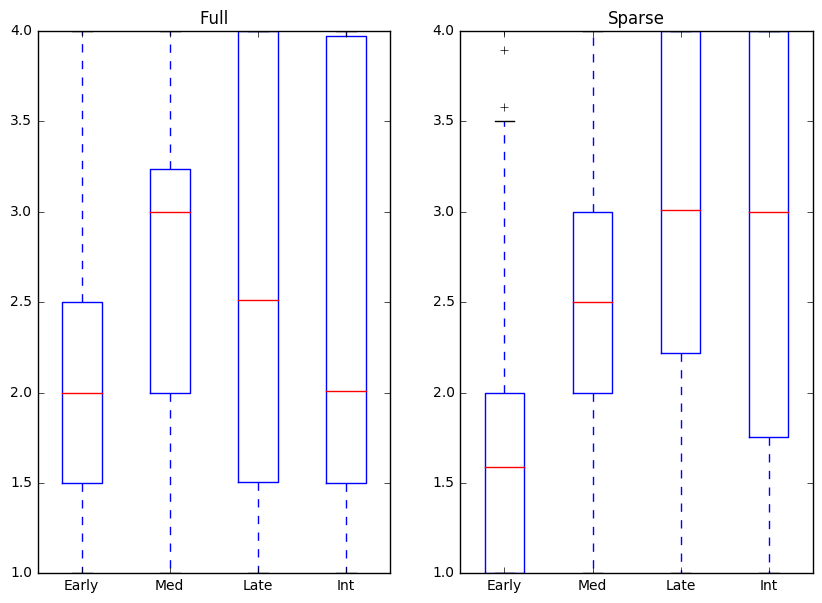

In [54]:
f, axarr = plt.subplots(1, 2, figsize=(10, 7))
ax = axarr.flatten()
ax[0].boxplot(meanRankFull, labels=['Early', 'Med', 'Late', 'Int'])
ax[0].set_title('Full')
ax[1].boxplot(meanRankSparse, labels=['Early', 'Med', 'Late', 'Int'])
ax[1].set_title('Sparse')

Open files /home/mqbssaby/transfer/syn/runArrayJob_Full98.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full98.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full98.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full98.p
Full:98: Mean rank
 [ 1.51  1.51  2.98  4.  ]


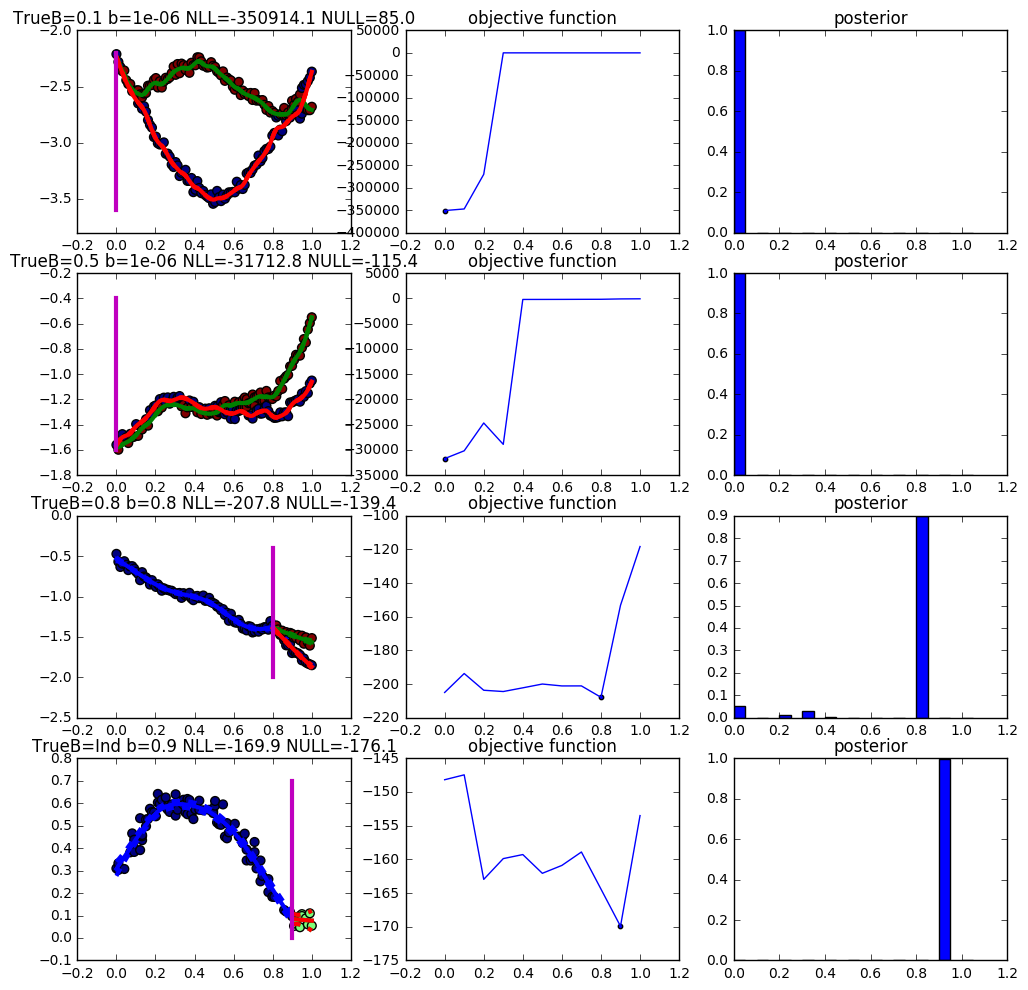

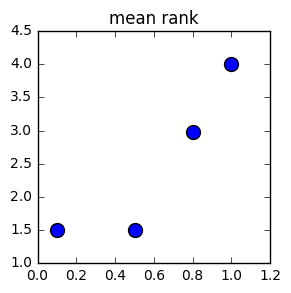

In [67]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
    
def plotBranchingModel(fSparse = False, nrun = 98, showAllB=False, nTrueB = 0):
    rallDescr = ['Full', 'Sparse']
    if(fSparse):
        rank = meanRankSparse
        posteriorB = posteriorBSparse
    else:
        rank = meanRankFull
        posteriorB = posteriorBFull
    bt = [nTrueB]
    if(showAllB):
        bt = np.arange(0, 4)
    f, ax = plt.subplots(len(bt), 3, figsize=(12, 12))
    ax = np.reshape(ax, (len(bt), 3))
    for b in bt:
        obj, gridSearchData, gridSearchGPs, BgridSearch, Btry = GetRunData(fSparse, nrun, b)
        assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
        iMin = np.argmin(obj)  # we could also plot other GPs on the grid
        gpPlot = gridSearchGPs[iMin]    
        # Plot GP
        _=plotBranchModel(gpPlot['candidateB'], gridSearchData['pt'], gridSearchData['Y'],
                          gpPlot['ttestl'], gpPlot['mul'], gpPlot['varl'],
                          gpPlot['Phi'], fPlotPhi=True, fPlotVar=True, ax=ax[b, 0])
        
        ax[b, 0].set_title('TrueB=%s b=%g NLL=%.1f NULL=%.1f' % (gridSearchData['trueBStr'],
                                                            gpPlot['candidateB'],
                                                            gpPlot['obj'],
                                                            gridSearchData['objInt']))
        ax[b, 1].set_title('objective function')
        ax[b, 1].plot(BgridSearch, obj, '-b')
        ax[b, 1].scatter(BgridSearch[iMin], obj[iMin], s=10)
        ax[b, 2].bar(BgridSearch, posteriorB[nrun-1, b, :], 0.05)  # experiments are 1-based
        ax[b, 2].set_title('posterior')
    
    f, ax = plt.subplots(1, figsize=(3, 3))    
    ax.scatter(Btry, rank[nrun-1, :], s=100)  # experiments are 1-based
    ax.set_title('mean rank')
    print('%s:%g: Mean rank\n' % (rallDescr[fSparse], nrun), rank[nrun-1, :])  # '\nposterior\n',np.round(posteriorB[nrun-1, nTrueB, :], 2)

_=interact(plotBranchingModel, fSparse=False, nrun=(1, 100),showAllB=True, nTrueB=(0, 3))

# Sparse GP performance

In [68]:
s = np.hstack([np.arange(1, meanRankSparse.shape[0]+1)[:,None], meanRankSparse])  # runs are 1-based
# s = np.sort(s, order=np.arange(1,4))
a = s[s[:,1].argsort(),]
a

array([[  46.   ,    1.   ,    2.   ,    3.225,    3.775],
       [  76.   ,    1.   ,    2.025,    3.79 ,    3.185],
       [  26.   ,    1.   ,    2.43 ,    4.   ,    2.57 ],
       [  28.   ,    1.   ,    3.   ,    4.   ,    2.   ],
       [  75.   ,    1.   ,    3.   ,    4.   ,    2.   ],
       [  74.   ,    1.   ,    3.56 ,    2.01 ,    3.43 ],
       [  60.   ,    1.   ,    2.   ,    3.145,    3.855],
       [  94.   ,    1.   ,    4.   ,    2.   ,    3.   ],
       [  33.   ,    1.   ,    2.   ,    3.19 ,    3.81 ],
       [  79.   ,    1.   ,    2.   ,    3.035,    3.965],
       [  36.   ,    1.   ,    2.   ,    3.725,    3.275],
       [  38.   ,    1.   ,    2.   ,    3.   ,    4.   ],
       [  43.   ,    1.   ,    3.   ,    4.   ,    2.   ],
       [  47.   ,    1.   ,    2.005,    2.995,    4.   ],
       [  48.   ,    1.   ,    2.   ,    3.   ,    4.   ],
       [  99.   ,    1.   ,    2.985,    4.   ,    2.015],
       [  55.   ,    1.   ,    2.5  ,    4.   ,    2.5  

### Bad ranking
1. The sampled data for the early point has not discernible braching point early on. A difficult case.
2. The medium branching point (TrueB=0.5) is not correctly identified even though it's easy. We see the objective function surface is nearly bimodal at t=0.0 and t=0.5. The posterior though is not - *is this a problem with our posterior calculation?* - see GetPosteriorB code.
3. The late branching point (TrueB=0.8) again is incorrectly identified as being early on (b=0.1). *We do not see a local minimum at the true value b=0.8. Is this because of sparse GP having too few points (21 per function (3))? *
4. For the sample from a single GP, the earliest point is identified as branching. The NULL model has the second lower negative log likelihood (-172) whereas the branching model has the highest neg log likelihood (~6000). Do we just compute a simple likelihood ratio given the vastly different scales here?

Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Sparse:5: Mean rank
 [ 4.   1.5  3.   1.5]


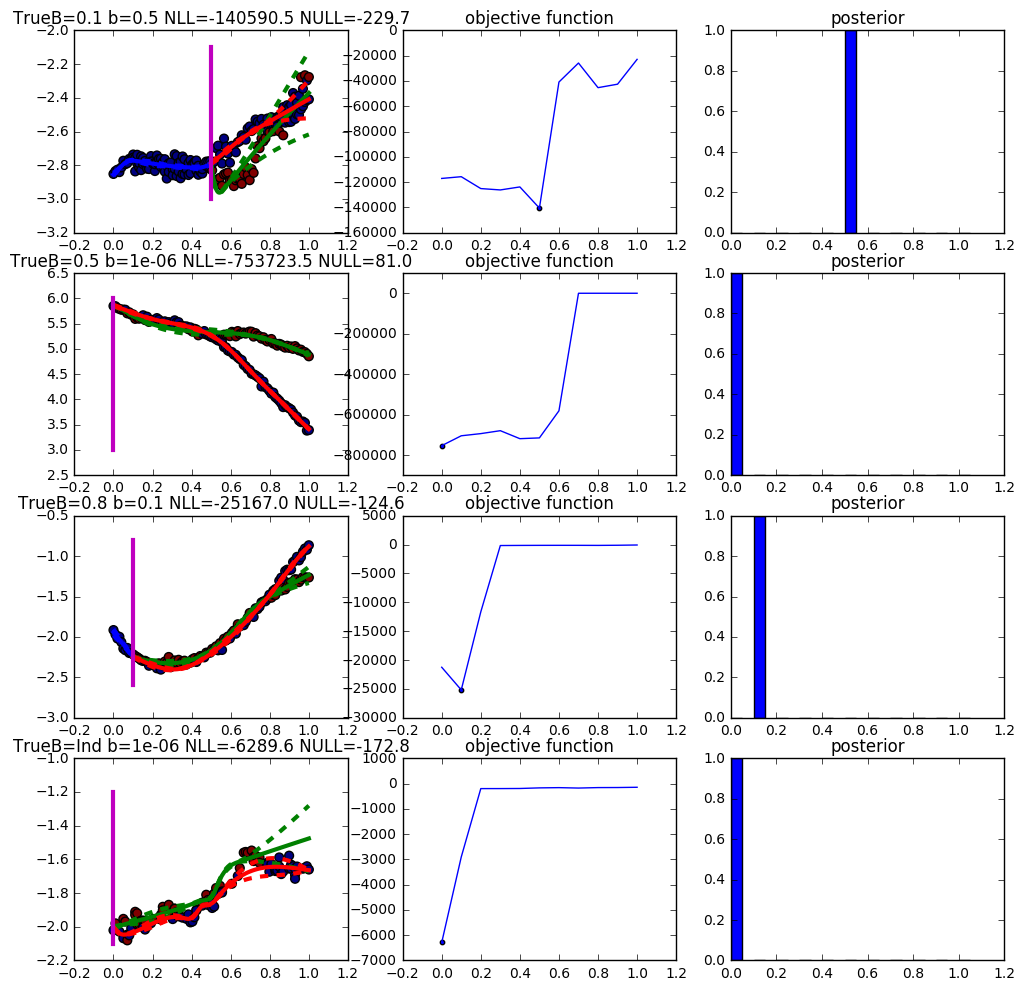

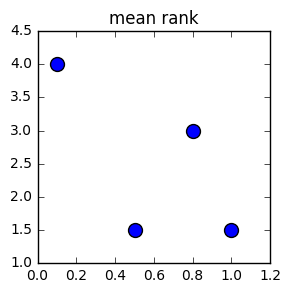

In [69]:
plotBranchingModel(fSparse = True, nrun = 5, showAllB=True)

### A good ranking
1. Note than for trueB=0.5 we identify 0.2 as the branching location. Agaun we see a multimodal posterior in the objective but the the posterior due to the log scale.

Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Sparse:46: Mean rank
 [ 1.     2.     3.225  3.775]


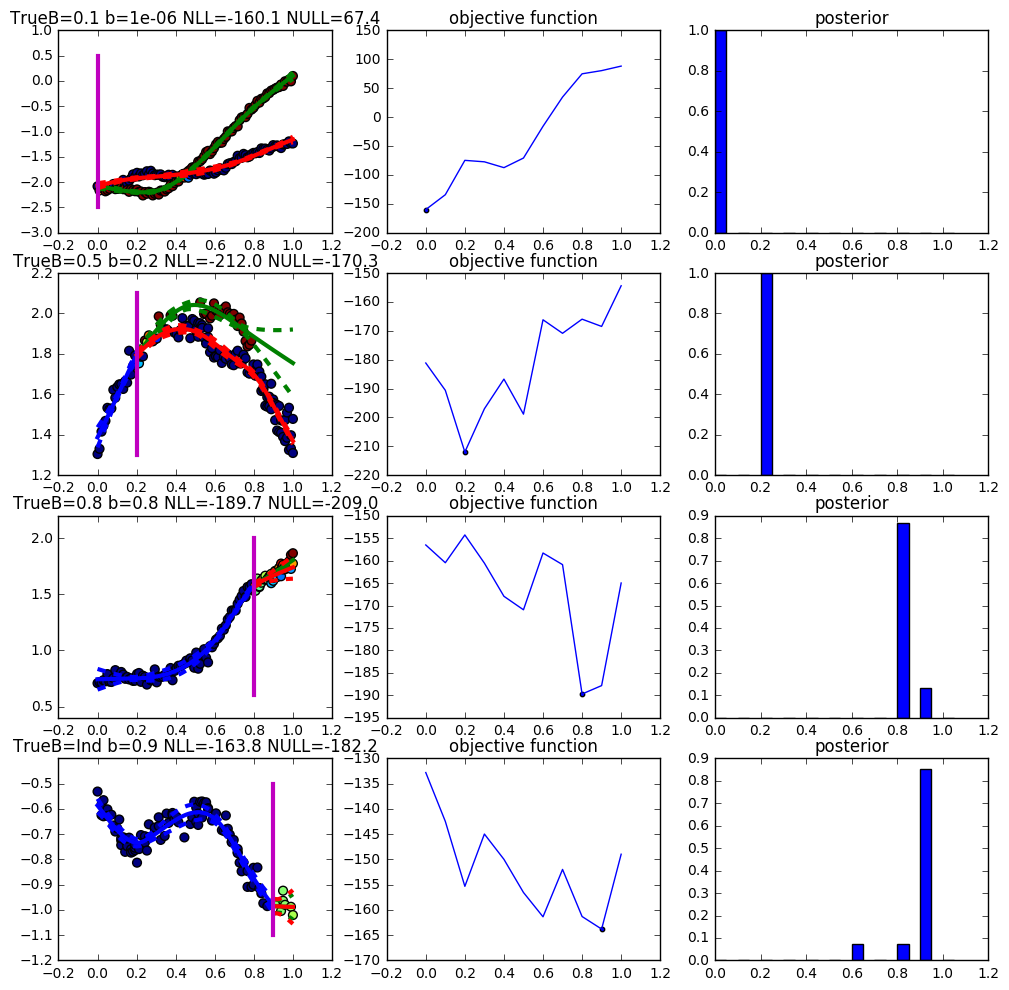

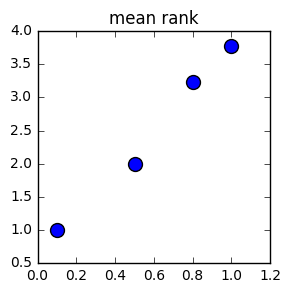

In [70]:
plotBranchingModel(fSparse = True, nrun = 46, showAllB=True)